In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
import utils

import os

out_root = '../../out/KNN'
root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

The local outlier factor is based on a concept of a local density, where locality is given by $k$ nearest neighbors, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers. 

* $k-distance(A)$ is the distance of object $A$ from its k neighbor.
* $reachability-distance_{k}(A,B)=max(k-distance(B),d(A,B))$
* local reachability density $ldr_{k}(A) = 1/ \left( \frac{\sum_{B\in N_k(A)}reachability-distance_k(A,B)}{|N_k(A)}\right)$

<center> $LOF_k(A) = \frac{\sum_{B\in N_k(A) \frac{lrd(B)}{lrd(A)}}}{|N_k(A)|}$ </center>

Thus:
* $LOF < 1$ means Higher density than neighbors (inlier)
* $LOF > 1$ means Lower density than neighbors (outlier)


In [3]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
import math

def KNN_slider(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    win_col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    win_ret = pd.DataFrame(columns = win_col)
    
    point_col = ['id', 'ts', 'val', 'is_in']
    point_ret = pd.DataFrame(columns = point_col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    prev_window = pd.DataFrame()
    
    root = 1
    model = LocalOutlierFactor(n_neighbors=root, algorithm='auto', metric = 'euclidean', contamination='auto', n_jobs=1)
    
    for start, end, window in gen:
        if len(window) == 0:
            continue
        
        if len(prev_window) + len(window) < expected_num_measurements:
            prev_window = prev_window.append(window)
            continue
        
        curr_data = prev_window.append(window) 
        to_fit = curr_data.iloc[:,1:3].values.reshape(-1,2)
        x = model.fit_predict(to_fit)
        
        n_out = 0
        n_in = 0
        # count outliers
        j = len(prev_window.values)
        for i in range(len(window)):
            frame = window.iloc[i,:]
            
            ts = frame[ts_index].astype('datetime64[ms]')
            value = frame[val_index]
            out = x[j]
            if out == -1:
                n_out += 1
            else:
                n_in += 1
            
            j+=1
            
            new_data = pd.DataFrame([[name, ts, value, out]], columns = point_col)
            point_ret = point_ret.append(new_data, sort = False)
            
            prev_window = prev_window.append(frame)
            prev_window = prev_window.iloc[1:,:]
        
        win_data = pd.DataFrame([[name, start, end, n_out, n_in, expected_num_measurements-n_in-n_out]], columns = win_col)
        win_ret = win_ret.append(win_data, sort = False)
            
        
    return win_ret, point_ret


In [4]:
if not os.path.isdir(out_root):
    os.mkdir(out_root)
    
res = []

<IPython.core.display.Javascript object>


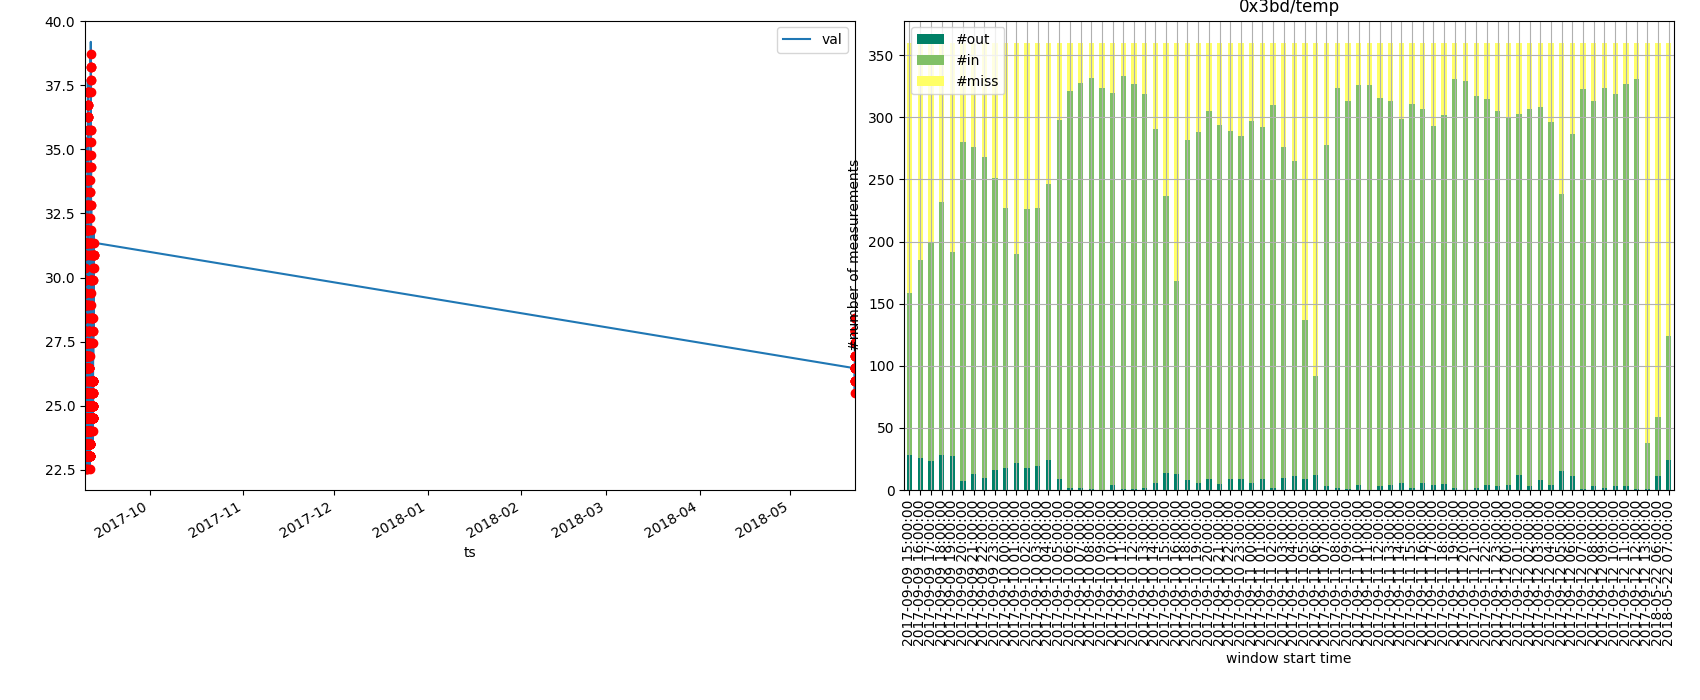

<IPython.core.display.Javascript object>


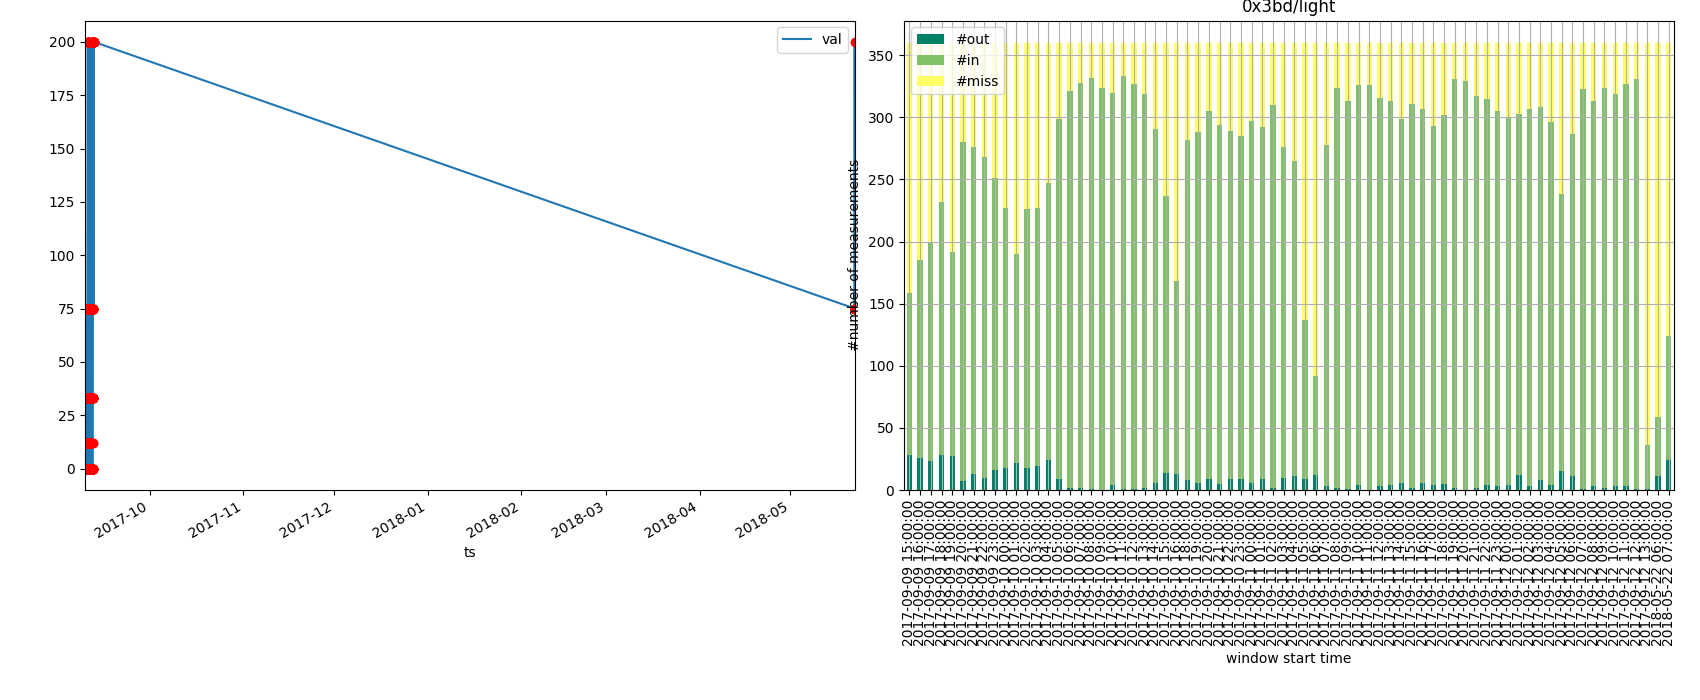

<IPython.core.display.Javascript object>


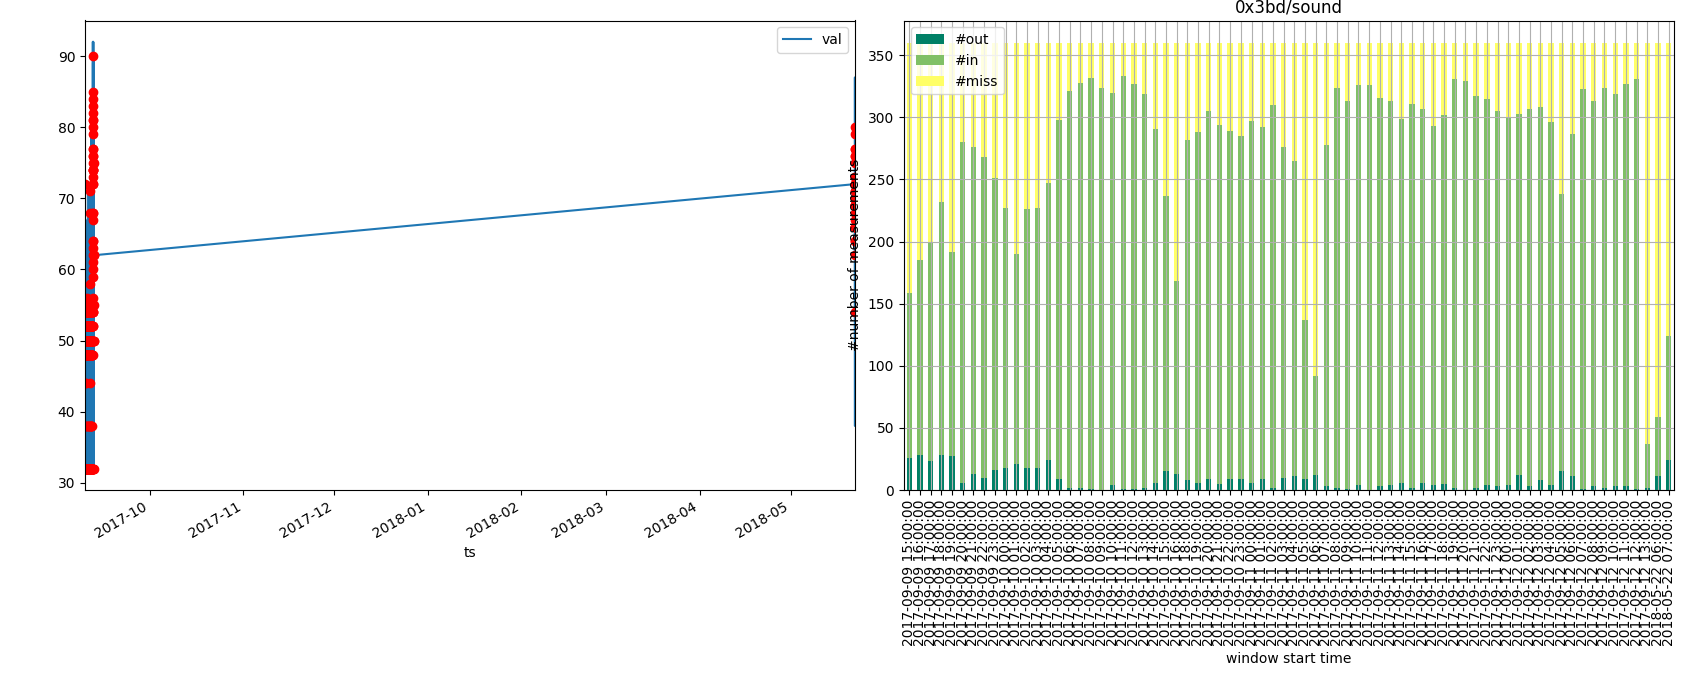

In [5]:
for x in [t_path[0], l_path[0], s_path[0]]:
    
    path = os.path.join(root, x)
    window_path = os.path.join(out_root, "win_" + x)
    out_path = os.path.join(out_root, "out_" + x)
    
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    try:
        y = pd.read_csv(window_path)
        y = y.astype({'start': 'datetime64[ms]', 'stop': 'datetime64[ms]'})
        x = pd.read_csv(out_path)
        x = x.astype({'ts': 'datetime64[ms]'})
    except Exception as e:
        print(e)
        y, x = KNN_slider(df)
        y.to_csv(window_path, index = None)
        x.to_csv(out_path, index= None)
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2], kind='line')
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[3]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

<IPython.core.display.Javascript object>


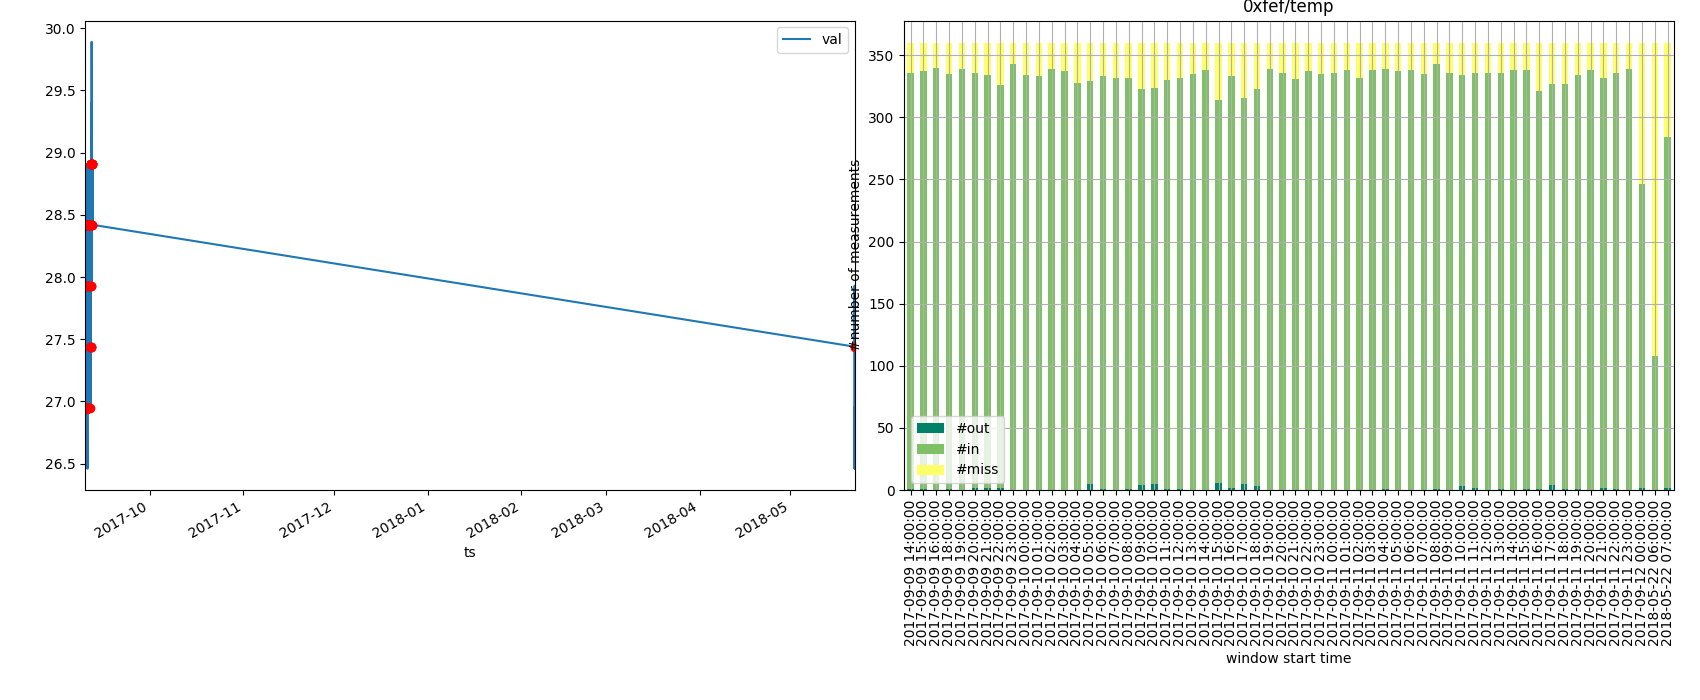

<IPython.core.display.Javascript object>


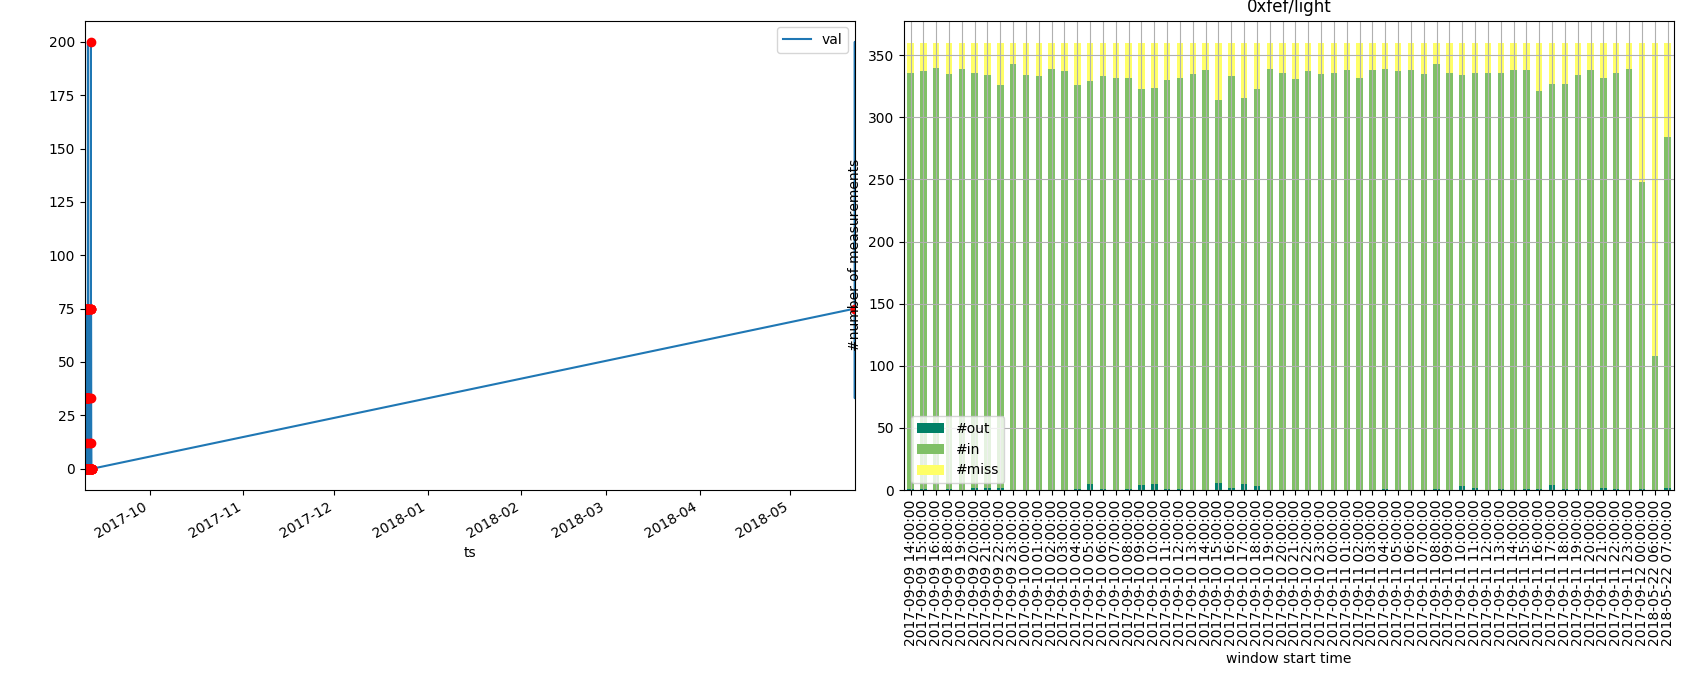

<IPython.core.display.Javascript object>


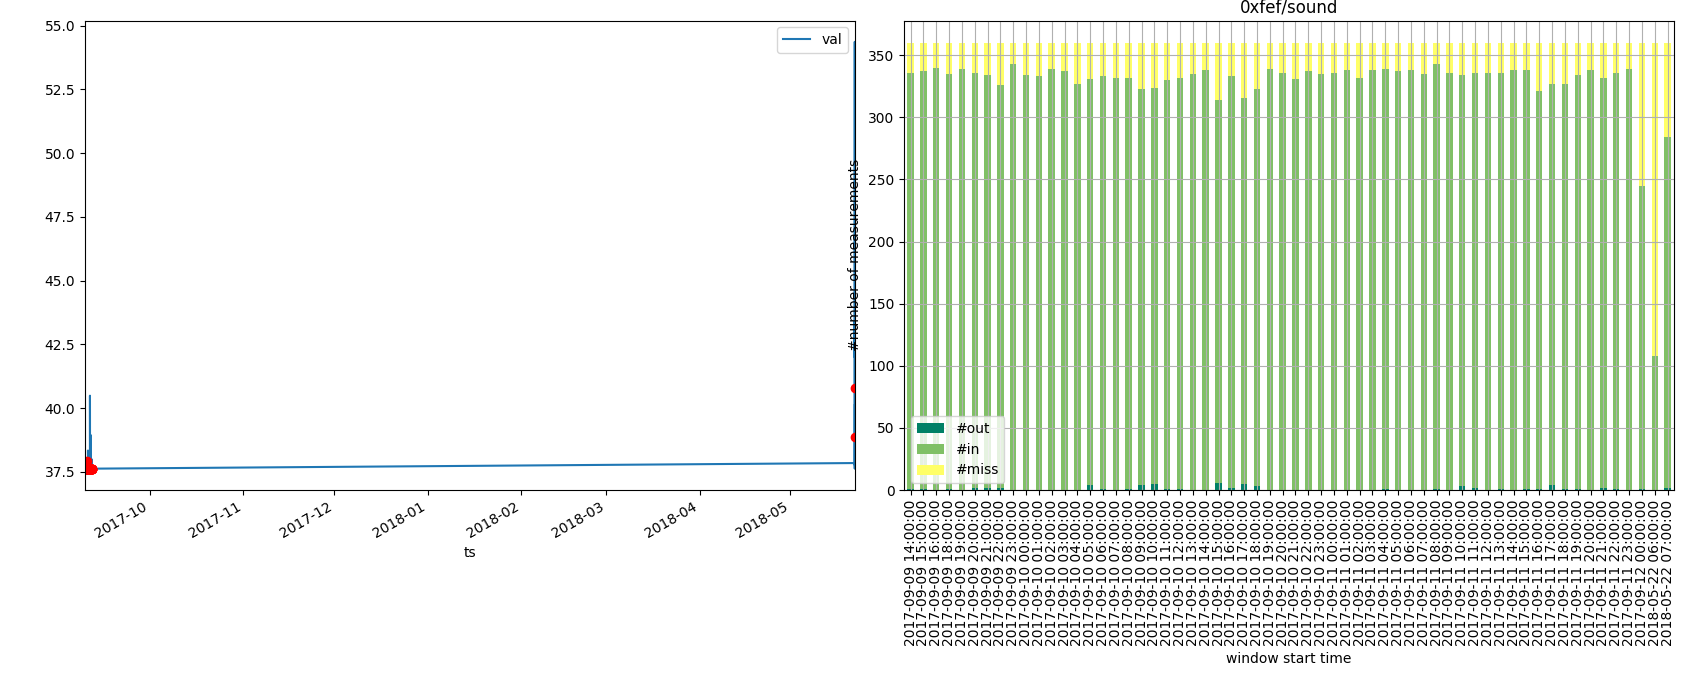

In [6]:
for x in [t_path[1], l_path[1], s_path[1]]:
    
    path = os.path.join(root, x)
    window_path = os.path.join(out_root, "win_" + x)
    out_path = os.path.join(out_root, "out_" + x)
    
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    try:
        y = pd.read_csv(window_path)
        y = y.astype({'start': 'datetime64[ms]', 'stop': 'datetime64[ms]'})
        x = pd.read_csv(out_path)
        x = x.astype({'ts': 'datetime64[ms]'})
    except Exception as e:
        print(e)
        y, x = KNN_slider(df)
        y.to_csv(window_path, index = None)
        x.to_csv(out_path, index= None)
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2], kind='line')
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[3]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

<IPython.core.display.Javascript object>


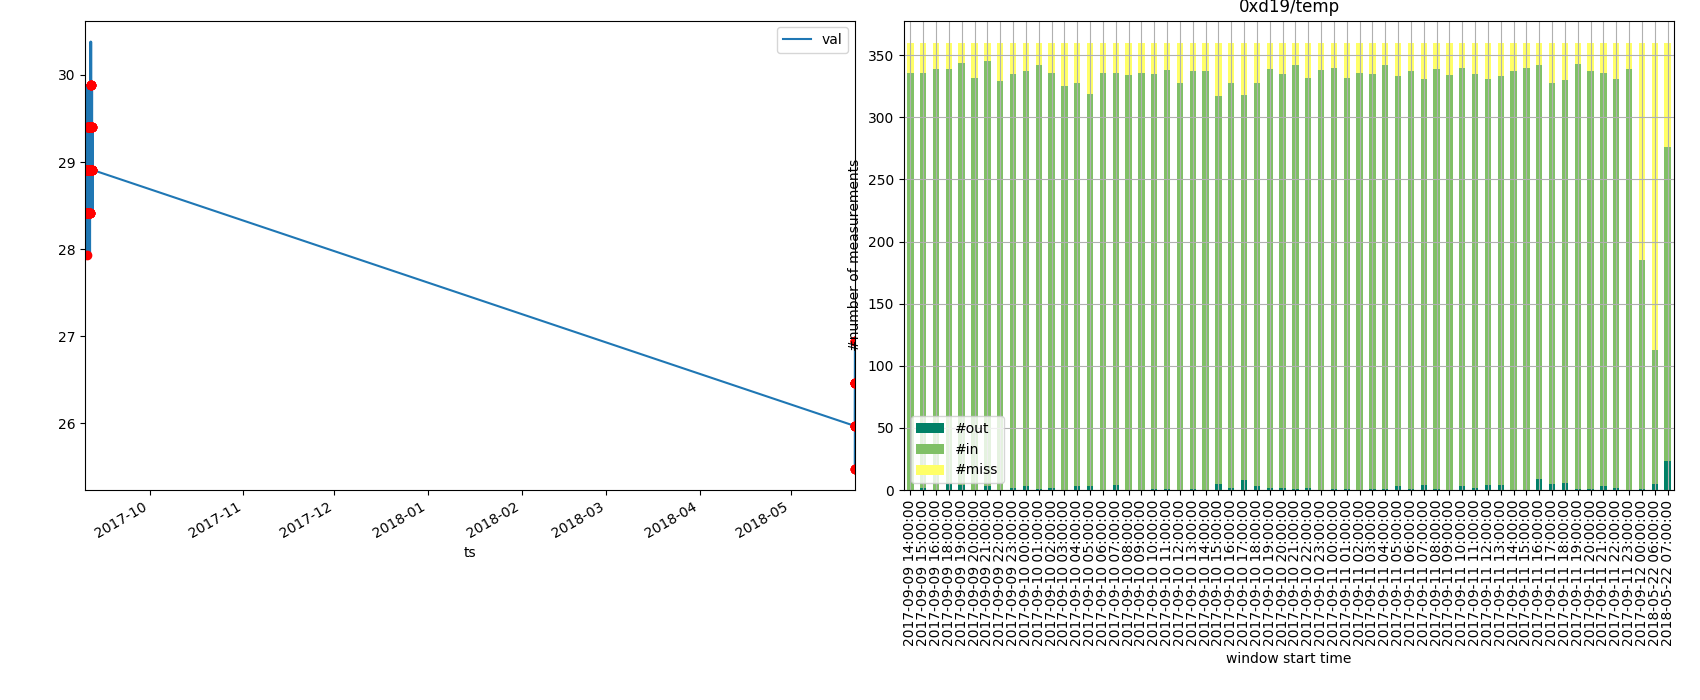

<IPython.core.display.Javascript object>


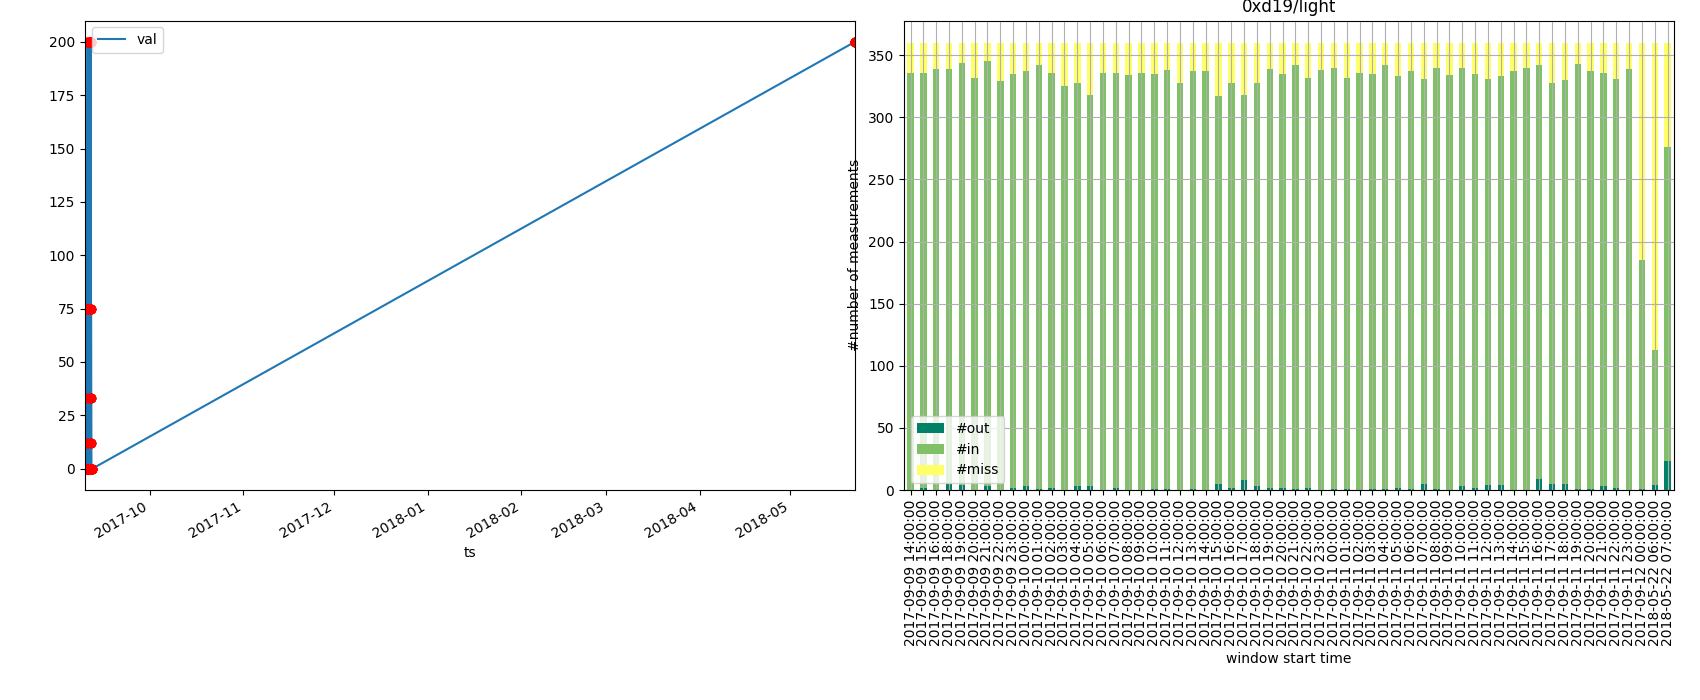

<IPython.core.display.Javascript object>


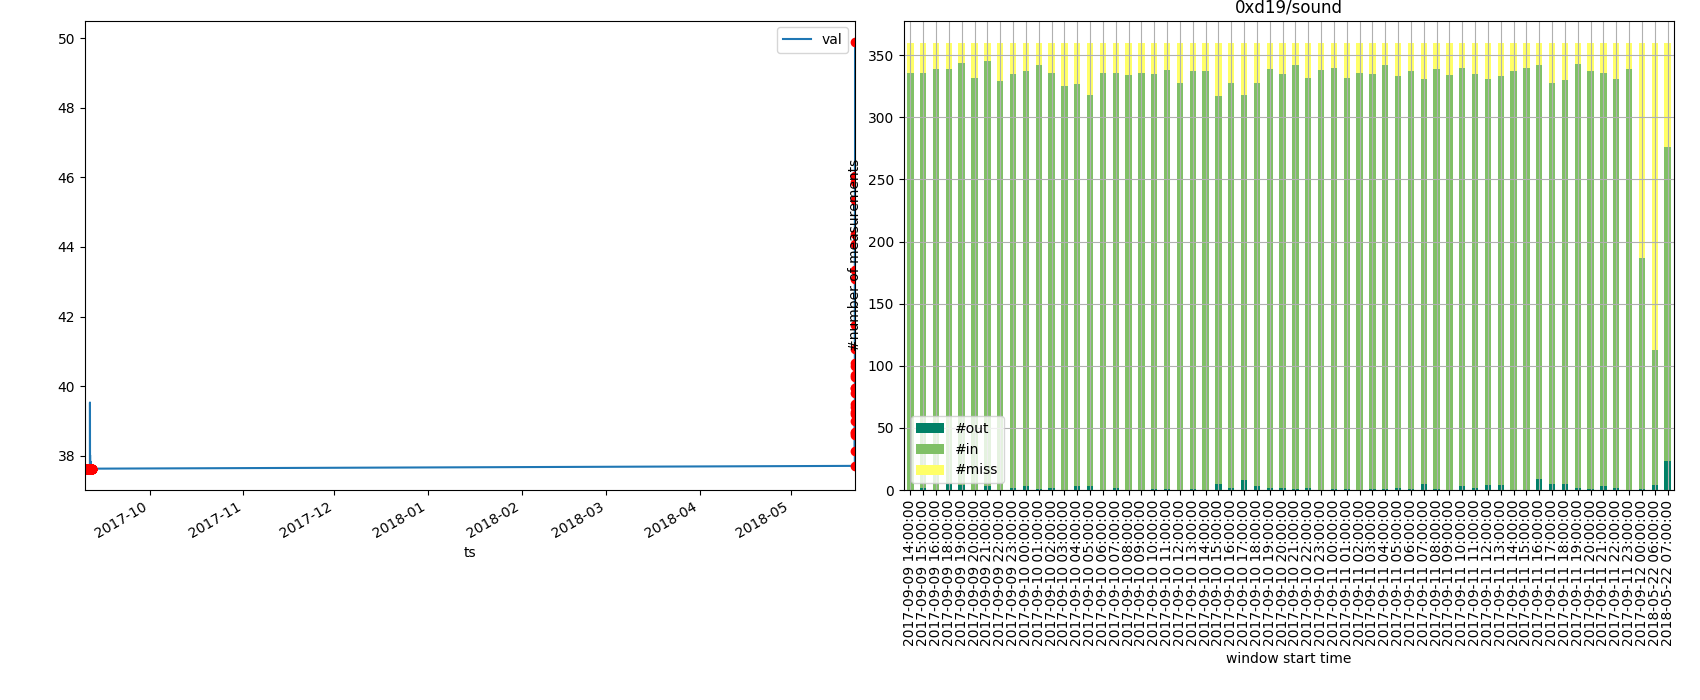

In [7]:
for x in [t_path[2], l_path[2], s_path[2]]:
    path = os.path.join(root, x)
    window_path = os.path.join(out_root, "win_" + x)
    out_path = os.path.join(out_root, "out_" + x)
    
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    try:
        y = pd.read_csv(window_path)
        y = y.astype({'start': 'datetime64[ms]', 'stop': 'datetime64[ms]'})
        x = pd.read_csv(out_path)
        x = x.astype({'ts': 'datetime64[ms]'})
    except Exception as e:
        print(e)
        y, x = KNN_slider(df)
        y.to_csv(window_path, index = None)
        x.to_csv(out_path, index= None)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2], kind='line')
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[3]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

In [8]:
print("|sensor|#outliers|#inliers|#missing|%outliers|\n|---|---|---|---|---|")
for val in res:
    print(val)

|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|596|19075|6249|3.0298408825174112|
|0x3bd/light|596|19075|6249|3.0298408825174112|
|0x3bd/sound|595|19076|6249|3.0247572568756036|
|0xfef/temp|66|19585|1949|0.3358607704442522|
|0xfef/light|66|19585|1949|0.3358607704442522|
|0xfef/sound|64|19587|1949|0.3256831713398809|
|0xd19/temp|142|19509|1949|0.7226095364103607|
|0xd19/light|138|19513|1949|0.7022543382016182|
|0xd19/sound|139|19512|1949|0.7073431377538039|


|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|596|19075|6249|3.0298408825174112|
|0x3bd/light|596|19075|6249|3.0298408825174112|
|0x3bd/sound|595|19076|6249|3.0247572568756036|
|0xfef/temp|66|19585|1949|0.3358607704442522|
|0xfef/light|66|19585|1949|0.3358607704442522|
|0xfef/sound|64|19587|1949|0.3256831713398809|
|0xd19/temp|142|19509|1949|0.7226095364103607|
|0xd19/light|138|19513|1949|0.7022543382016182|
|0xd19/sound|139|19512|1949|0.7073431377538039|
